Saving Image_all.zip to Image_all (1).zip
✅ Extracted to /content/Image_all
✅ Loaded images: (4017, 129, 135)
✅ Created sequences: (4010, 7, 129, 135, 1) Labels: (4010, 129, 135, 1)
✅ Train: (2807, 7, 129, 135, 1) | Val: (802, 7, 129, 135, 1) | Test: (401, 7, 129, 135, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - loss: 8.8805e-04 - mae: 0.0087 - val_loss: 5.1453e-04 - val_mae: 0.0040
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 219ms/step - loss: 4.9131e-04 - mae: 0.0042 - val_loss: 4.9435e-04 - val_mae: 0.0043
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - loss: 4.5641e-04 - mae: 0.0042 - val_loss: 4.8224e-04 - val_mae: 0.0045
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - loss: 4.6247e-04 - mae: 0.0044 - val_loss: 4.7504e-04 - val_mae: 0.0044
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 218ms/step - loss: 4.4695e-04 - mae: 0.0043 - val_loss: 4.6584e-04 - val_mae: 0.0043
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - loss: 4.4058e-04 - mae: 0.0042 - val_loss: 4.6141e-04 - val_mae: 0.0042
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 4.2122e-04 - mae: 0.0040 - val_loss: 4.5556e-04 - val_mae: 0.0040
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - loss: 4.1728e-04 - mae: 0.0039 - val_los

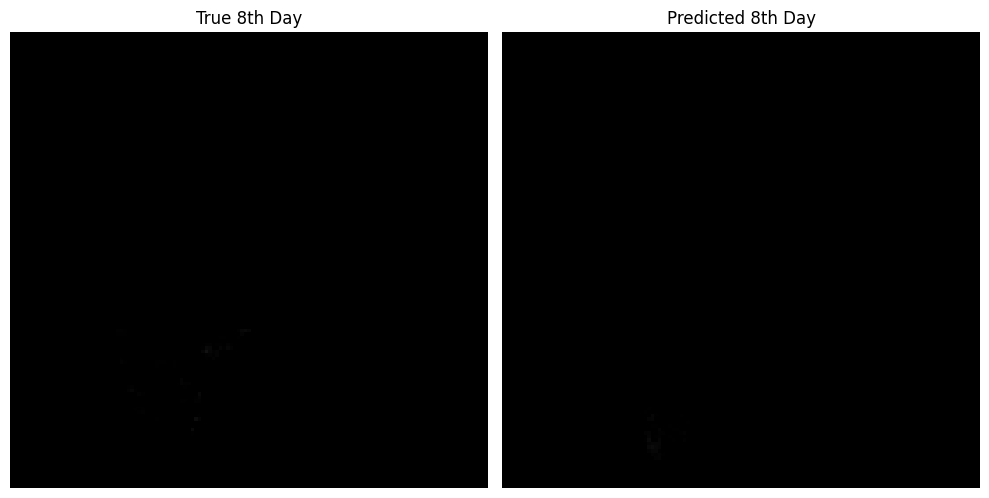

In [ ]:
# --- Step 1: Set Sequence Length ---
SEQ_LENGTH = 7  # ← Change to 15 or 30 to compare sequence lengths

# --- Step 2: Upload and Extract ZIP ---
import zipfile, os
from google.colab import files

uploaded = files.upload()
for fname in uploaded:
    if fname.endswith('.zip'):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("/content/Image_all")
print("✅ Extracted to /content/Image_all")

# --- Step 3: Import Libraries ---
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- Step 4: Load Grayscale Rainfall Images ---
def load_image_data(base_dir, start_year=2013, end_year=2023):
    all_images = []
    for year in range(start_year, end_year + 1):
        year_folder = os.path.join(base_dir, str(year))
        if not os.path.isdir(year_folder):
            continue
        image_files = sorted([f for f in os.listdir(year_folder) if f.endswith('.png') and f.startswith('IMD_RAIN_')])
        for img_file in image_files:
            img_path = os.path.join(year_folder, img_file)
            with Image.open(img_path) as img:
                img_gray = img.convert('L')
                img_array = np.array(img_gray, dtype=np.float32) / 255.0
                all_images.append(img_array)
    return np.array(all_images)

# --- Step 5: Create Sequences ---
def create_sequences(all_images, seq_length):
    X, y = [], []
    for i in range(len(all_images) - seq_length):
        X.append(all_images[i: i + seq_length])
        y.append(all_images[i + seq_length])
    X = np.array(X)[..., np.newaxis]
    y = np.array(y)[..., np.newaxis]
    return X, y

# --- Step 6: Train/Val/Test Split ---
def train_val_test_split(X, y, test_ratio=0.1, val_ratio=0.2):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_size_adjusted, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

# --- Step 7: Build CNN-LSTM Model (Fixed Architecture) ---
def build_cnn_lstm_model(input_shape):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(129, 135, 1)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(0.3))

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)

    # ✅ Fixed LSTM units for all sequence lengths
    lstm_out = layers.Bidirectional(layers.LSTM(256, activation='tanh'))(td_cnn)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    dense_out = layers.Dense(129 * 135, activation='relu')(lstm_out)
    output_layer = layers.Reshape((129, 135, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="CNN_LSTM_Rainfall")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

# --- Step 8: Load Data and Train ---
base_dir = "/content/Image_all/Image_all"

all_images = load_image_data(base_dir)
print("✅ Loaded images:", all_images.shape)

X, y = create_sequences(all_images, seq_length=SEQ_LENGTH)
print("✅ Created sequences:", X.shape, "Labels:", y.shape)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)
print("✅ Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

model = build_cnn_lstm_model(input_shape=(SEQ_LENGTH, 129, 135, 1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop]
)

# --- Step 9: Evaluation ---
test_loss, test_mae = model.evaluate(X_test, y_test)
print("📉 Test MSE:", test_loss)
print("📉 Test MAE:", test_mae)

y_pred = model.predict(X_test)
r2 = r2_score(y_test.reshape(len(y_test), -1), y_pred.reshape(len(y_pred), -1))
print(f"✅ Test R² Score ({SEQ_LENGTH}-day):", r2)

# --- Step 10: Visualize One Prediction ---
true_img = (y_test[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(true_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"True {SEQ_LENGTH+1}th Day")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pred_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Predicted {SEQ_LENGTH+1}th Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# --- 1. Setup Sequence Length ---
SEQ_LENGTH = 15  # Change to 7 or 30 for other runs

# --- 2. Upload ZIP and Extract ---
from google.colab import files
import zipfile, os

uploaded = files.upload()
for fname in uploaded:
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, "r") as zip_ref:
            zip_ref.extractall("/content/Image_all")
print("✅ ZIP Extracted.")

# --- 3. Imports ---
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- 4. Collect Image Paths ---
def collect_image_paths(base_dir, start_year=2013, end_year=2023):
    all_paths = []
    for year in range(start_year, end_year + 1):
        folder = os.path.join(base_dir, str(year))
        if os.path.isdir(folder):
            files_sorted = sorted([f for f in os.listdir(folder) if f.endswith('.png') and f.startswith('IMD_RAIN_')])
            all_paths.extend([os.path.join(folder, f) for f in files_sorted])
    return all_paths

# --- 5. Generator ---
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len, batch_size=16, shuffle=False):
        self.image_paths = image_paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths) - seq_len)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for idx in batch_indices:
            seq = [self._load_image(self.image_paths[j]) for j in range(idx, idx + self.seq_len)]
            target = self._load_image(self.image_paths[idx + self.seq_len])
            X_batch.append(seq)
            y_batch.append(target)
        X = np.expand_dims(np.array(X_batch), -1)
        y = np.expand_dims(np.array(y_batch), -1)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_image(self, path):
        with Image.open(path) as img:
            return np.array(img.convert('L'), dtype=np.float32) / 255.0

# --- 6. Build Model ---
def build_cnn_lstm_model(input_shape):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(129, 135, 1)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(0.3))

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)
    lstm_out = layers.Bidirectional(layers.LSTM(256, activation='tanh'))(td_cnn)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    dense_out = layers.Dense(129 * 135, activation='relu')(lstm_out)
    output_layer = layers.Reshape((129, 135, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    return model

# --- 7. Prepare Data ---
base_path = "/content/Image_all/Image_all"  # Adjust path if needed
all_image_paths = collect_image_paths(base_path)
print("✅ Total images:", len(all_image_paths))

total_seq = len(all_image_paths) - SEQ_LENGTH
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)

train_paths = all_image_paths[:-(test_size + val_size)]
val_paths = all_image_paths[-(test_size + val_size):-test_size]
test_paths = all_image_paths[-test_size:]

train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LENGTH, batch_size=16, shuffle=True)
val_gen   = RainfallSequenceGenerator(val_paths, seq_len=SEQ_LENGTH, batch_size=16)
test_gen  = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LENGTH, batch_size=16)

# --- 8. Train the Model ---
model = build_cnn_lstm_model(input_shape=(SEQ_LENGTH, 129, 135, 1))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)


Saving Image_all.zip to Image_all.zip
✅ ZIP Extracted.
✅ Total images: 4017


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 94s 422ms/step - loss: 8.6820e-04 - mae: 0.0085 - val_loss: 5.1242e-04 - val_mae: 0.0041
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 417ms/step - loss: 4.9430e-04 - mae: 0.0043 - val_loss: 4.9026e-04 - val_mae: 0.0044
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 419ms/step - loss: 4.7357e-04 - mae: 0.0044 - val_loss: 4.7710e-04 - val_mae: 0.0045
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 419ms/step - loss: 4.4921e-04 - mae: 0.0044 - val_loss: 4.6489e-04 - val_mae: 0.0044
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - loss: 4.4696e-04 - mae: 0.0044 - val_loss: 4.5478e-04 - val_mae: 0.0041
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 433ms/step - loss: 4.4001e-04 - mae: 0.0041 - val_loss: 4.4612e-04 - val_mae: 0.0040
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 420ms/step - loss: 4.1993e-04 - mae: 0.0040 - val_loss: 4.3985e-04 - val_mae: 0.0039
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 418ms/step - loss: 4.3705e-04 - mae: 0.0041 - val_los

In [ ]:
# --- Save the model after training ---
model.save("/content/cnn_lstm_15day_model.h5")
print("✅ Model saved to /content/cnn_lstm_15day_model.h5")


✅ Model saved to /content/cnn_lstm_15day_model.h5


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


⏳ Predicting one batch at a time...

✅ Test R² Score (15-day): 0.7474
📉 Test MSE: 0.000327
📉 Test MAE: 0.003058


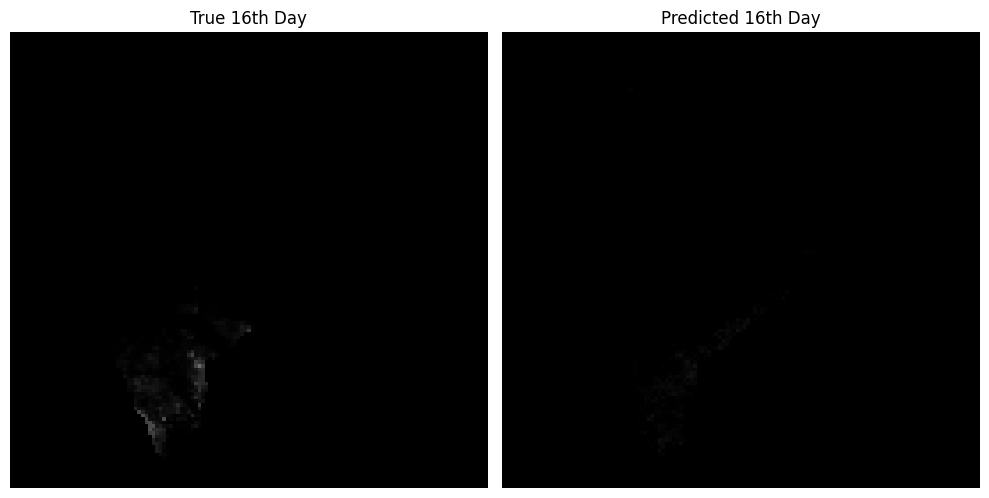

In [ ]:
# === STEP 1: Imports ===
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# === STEP 2: Reload model ===
model = tf.keras.models.load_model(
    "/content/cnn_lstm_15day_model.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)


# === STEP 3: Setup Parameters ===
SEQ_LENGTH = 15
base_path = "/content/Image_all/Image_all"  # Adjust if needed

# === STEP 4: Collect Paths ===
def collect_image_paths(base_dir, start_year=2013, end_year=2023):
    all_paths = []
    for year in range(start_year, end_year + 1):
        folder = os.path.join(base_dir, str(year))
        if os.path.isdir(folder):
            files_sorted = sorted([f for f in os.listdir(folder) if f.endswith('.png') and f.startswith('IMD_RAIN_')])
            all_paths.extend([os.path.join(folder, f) for f in files_sorted])
    return all_paths

all_image_paths = collect_image_paths(base_path)
total_seq = len(all_image_paths) - SEQ_LENGTH
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)
test_paths = all_image_paths[-test_size:]

# === STEP 5: Define Generator ===
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len, batch_size=16, shuffle=False):
        self.image_paths = image_paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths) - seq_len)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for idx in batch_indices:
            seq = [self._load_image(self.image_paths[j]) for j in range(idx, idx + self.seq_len)]
            target = self._load_image(self.image_paths[idx + self.seq_len])
            X_batch.append(seq)
            y_batch.append(target)
        X = np.expand_dims(np.array(X_batch), -1)
        y = np.expand_dims(np.array(y_batch), -1)
        return X, y

    def _load_image(self, path):
        with Image.open(path) as img:
            return np.array(img.convert('L'), dtype=np.float32) / 255.0

# === STEP 6: Predict Safely, Batch-by-Batch ===
test_gen = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LENGTH, batch_size=1)

y_true_all, y_pred_all = [], []
print("⏳ Predicting one batch at a time...")

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model.predict(x_batch, verbose=0)
    y_true_all.append(y_batch[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# === STEP 7: Evaluate ===
r2 = r2_score(y_true_all.reshape(len(y_true_all), -1), y_pred_all.reshape(len(y_pred_all), -1))
mse = np.mean((y_true_all - y_pred_all) ** 2)
mae = np.mean(np.abs(y_true_all - y_pred_all))

print(f"\n✅ Test R² Score (15-day): {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# === STEP 8: Visualize Sample ===
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray', vmin=0, vmax=255)
plt.title("True 16th Day")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray', vmin=0, vmax=255)
plt.title("Predicted 16th Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# --- 1. Set sequence length ---
SEQ_LENGTH = 30

# --- 2. Extract and prepare data ---
from google.colab import files
import zipfile, os

uploaded = files.upload()
for fname in uploaded:
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, "r") as zip_ref:
            zip_ref.extractall("/content/Image_all")
print("✅ ZIP extracted.")

# --- 3. Imports ---
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- 4. Collect image paths ---
def collect_image_paths(base_dir, start_year=2013, end_year=2023):
    all_paths = []
    for year in range(start_year, end_year + 1):
        folder = os.path.join(base_dir, str(year))
        if os.path.isdir(folder):
            files_sorted = sorted([f for f in os.listdir(folder) if f.endswith('.png') and f.startswith('IMD_RAIN_')])
            all_paths.extend([os.path.join(folder, f) for f in files_sorted])
    return all_paths

# --- 5. Define generator ---
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len, batch_size=16, shuffle=False):
        self.image_paths = image_paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths) - seq_len)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for idx in batch_indices:
            seq = [self._load_image(self.image_paths[j]) for j in range(idx, idx + self.seq_len)]
            target = self._load_image(self.image_paths[idx + self.seq_len])
            X_batch.append(seq)
            y_batch.append(target)
        X = np.expand_dims(np.array(X_batch), -1)
        y = np.expand_dims(np.array(y_batch), -1)
        return X, y

    def _load_image(self, path):
        with Image.open(path) as img:
            return np.array(img.convert('L'), dtype=np.float32) / 255.0

# --- 6. Prepare dataset splits ---
base_path = "/content/Image_all/Image_all"
all_image_paths = collect_image_paths(base_path)
print("✅ Total images found:", len(all_image_paths))

total_seq = len(all_image_paths) - SEQ_LENGTH
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)

train_paths = all_image_paths[:-(test_size + val_size)]
val_paths   = all_image_paths[-(test_size + val_size):-test_size]
test_paths  = all_image_paths[-test_size:]

train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LENGTH, batch_size=16, shuffle=True)
val_gen   = RainfallSequenceGenerator(val_paths, seq_len=SEQ_LENGTH, batch_size=16)
test_gen  = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LENGTH, batch_size=16)

# --- 7. Define CNN-LSTM model ---
def build_cnn_lstm_model(input_shape):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(129, 135, 1)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(0.3))

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)
    lstm_out = layers.Bidirectional(layers.LSTM(256, activation='tanh'))(td_cnn)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    dense_out = layers.Dense(129 * 135, activation='relu')(lstm_out)
    output_layer = layers.Reshape((129, 135, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])
    return model

# --- 8. Train and Save Model ---
model = build_cnn_lstm_model(input_shape=(SEQ_LENGTH, 129, 135, 1))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

# --- Save the trained model ---
model.save("/content/cnn_lstm_30day_model.h5")
print("✅ Model saved as cnn_lstm_30day_model.h5")


Saving Image_all.zip to Image_all (1).zip
✅ ZIP extracted.
✅ Total images found: 4017


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 171s 801ms/step - loss: 8.8494e-04 - mae: 0.0088 - val_loss: 5.1405e-04 - val_mae: 0.0041
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 779ms/step - loss: 4.5946e-04 - mae: 0.0040 - val_loss: 4.9135e-04 - val_mae: 0.0043
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 136s 779ms/step - loss: 4.8459e-04 - mae: 0.0044 - val_loss: 4.7964e-04 - val_mae: 0.0044
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 774ms/step - loss: 4.5066e-04 - mae: 0.0044 - val_loss: 4.6635e-04 - val_mae: 0.0044
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 775ms/step - loss: 4.4425e-04 - mae: 0.0043 - val_loss: 4.6121e-04 - val_mae: 0.0042
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 774ms/step - loss: 4.2421e-04 - mae: 0.0041 - val_loss: 4.5219e-04 - val_mae: 0.0041
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 142s 814ms/step - loss: 4.2517e-04 - mae: 0.0041 - val_loss: 4.5015e-04 - val_mae: 0.0040
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 776ms/step - loss: 4.1805e-04 - mae: 0.0039 -

✅ Model saved as cnn_lstm_30day_model.h5


⏳ Predicting one batch at a time...

✅ Test R² Score (30-day): 0.7361
📉 Test MSE: 0.000347
📉 Test MAE: 0.003293


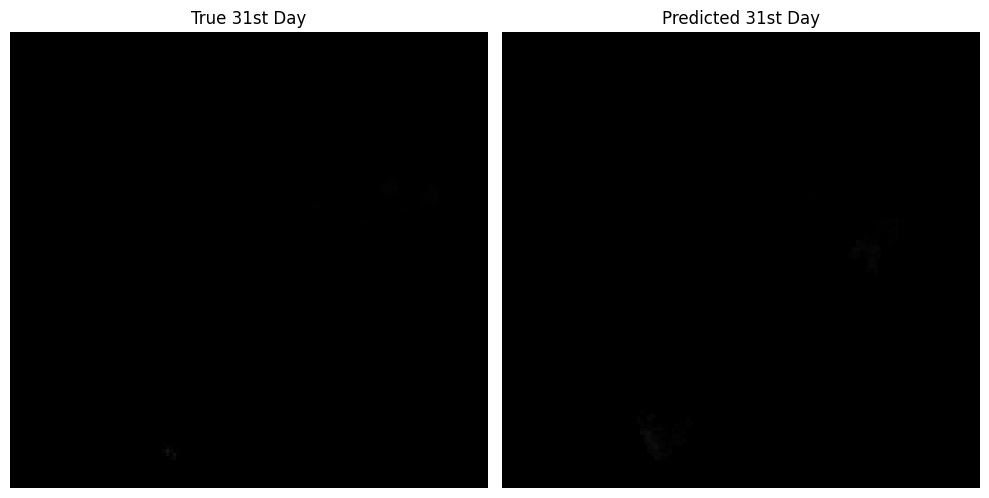

In [ ]:
# Use existing model and variables — no need to reload

# Reinitialize test generator with batch size 1 for safe prediction
test_gen = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LENGTH, batch_size=1)

# Predict safely, batch by batch
y_true_all, y_pred_all = [], []
print("⏳ Predicting one batch at a time...")

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model.predict(x_batch, verbose=0)
    y_true_all.append(y_batch[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute metrics
from sklearn.metrics import r2_score
r2 = r2_score(y_true_all.reshape(len(y_true_all), -1), y_pred_all.reshape(len(y_pred_all), -1))
mse = np.mean((y_true_all - y_pred_all) ** 2)
mae = np.mean(np.abs(y_true_all - y_pred_all))

print(f"\n✅ Test R² Score (30-day): {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# Visualize one prediction
import matplotlib.pyplot as plt
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray', vmin=0, vmax=255)
plt.title("True 31st Day")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray', vmin=0, vmax=255)
plt.title("Predicted 31st Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import zipfile, os
from google.colab import files

uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

extract_dir = "/content/Image_all"
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extracted to", extract_dir)


Saving Image_all.zip to Image_all (2).zip
✅ Extracted to /content/Image_all


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

SEQ_LEN = 15
BATCH_SIZE = 8

def collect_image_paths(base_dir, start_year=2013, end_year=2023):
    all_paths = []
    for year in range(start_year, end_year + 1):
        folder = os.path.join(base_dir, str(year))
        if os.path.isdir(folder):
            files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
            all_paths.extend([os.path.join(folder, f) for f in files])
    return all_paths

all_image_paths = collect_image_paths("/content/Image_all/Image_all")


# Train/Val/Test split
total = len(all_image_paths) - SEQ_LEN
test_size = int(0.1 * total)
val_size = int(0.2 * total)

train_paths = all_image_paths[:-(val_size + test_size)]
val_paths   = all_image_paths[-(val_size + test_size):-test_size]
test_paths  = all_image_paths[-test_size:]

class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, seq_len, batch_size=8, shuffle=False):
        self.paths = paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(paths) - seq_len)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []
        for i in batch_idx:
            seq = [self._load_image(self.paths[j]) for j in range(i, i+self.seq_len)]
            label = self._load_image(self.paths[i + self.seq_len])
            X.append(seq)
            y.append(label)
        return np.expand_dims(np.array(X), -1), np.expand_dims(np.array(y), -1)

    def _load_image(self, path):
        img = Image.open(path).convert('L')
        return np.array(img, dtype=np.float32) / 255.0

train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = RainfallSequenceGenerator(val_paths, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
test_gen  = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LEN, batch_size=1)


In [ ]:
from tensorflow.keras import layers, models

def build_cnn_lstm_model(input_shape=(15, 129, 135, 1)):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(129, 135, 1)))
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    cnn.add(layers.MaxPooling2D((2,2)))
    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.Flatten())

    input_layer = layers.Input(shape=input_shape)
    x = layers.TimeDistributed(cnn)(input_layer)
    x = layers.LSTM(64, activation='tanh')(x)
    x = layers.Dense(129*135, activation='relu')(x)
    output_layer = layers.Reshape((129, 135, 1))(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn_lstm_model()
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 15, 129, 135,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 67584)      │        23,296 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │    17,318,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17415)          │     1,131,975 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 129, 135, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,473,415 (70.47 MB)

 Trainable params: 18,473,415 (70.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 108ms/step - loss: 4.4839e-04 - mae: 0.0041 - val_loss: 3.9891e-04 - val_mae: 0.0041
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - loss: 3.8378e-04 - mae: 0.0037 - val_loss: 3.8085e-04 - val_mae: 0.0038
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - loss: 3.2612e-04 - mae: 0.0033 - val_loss: 3.7012e-04 - val_mae: 0.0037
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - loss: 3.3711e-04 - mae: 0.0034 - val_loss: 3.6790e-04 - val_mae: 0.0034
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - loss: 3.1157e-04 - mae: 0.0032 - val_loss: 3.7123e-04 - val_mae: 0.0036
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - loss: 3.0381e-04 - mae: 0.0032 - val_loss: 3.7107e-04 - val_mae: 0.0033
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - loss: 2.8565e-04 - mae: 0.0031 - val_loss: 3.7917e-04 - val_mae: 0.0036
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - loss: 2.6054e-04 - mae: 0.0030 - val_los

In [ ]:
model.save("/content/cnn_lstm_15day_final_model_10epoch.h5")
print("✅ Model saved as cnn_lstm_15day_final_model.h5")


✅ Model saved as cnn_lstm_15day_final_model.h5


✅ Model loaded and compiled.
⏳ Predicting...

✅ Test R² Score (15-day): 0.5693
📉 Test MSE: 0.000318
📉 Test MAE: 0.002969


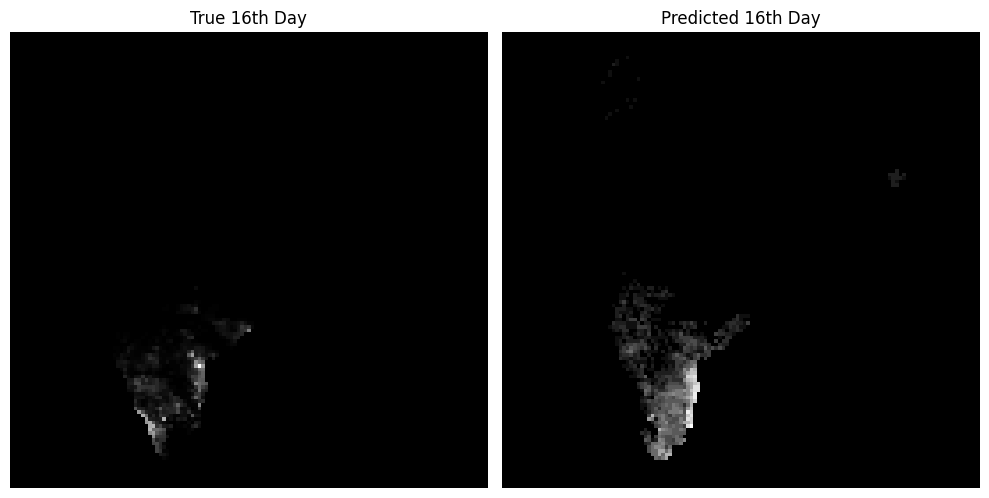

In [ ]:
# === Imports ===
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Constants ===
SEQ_LEN = 15
BATCH_SIZE = 1
IMAGE_DIR = "/content/Image_all/Image_all"  # Adjust if needed
MODEL_PATH = "/content/cnn_lstm_15day_final_model_10epoch.h5"

# === Collect image paths ===
def collect_image_paths(base_dir, start_year=2013, end_year=2023):
    all_paths = []
    for year in range(start_year, end_year + 1):
        year_dir = os.path.join(base_dir, str(year))
        if os.path.isdir(year_dir):
            files = sorted([f for f in os.listdir(year_dir) if f.endswith('.png')])
            all_paths.extend([os.path.join(year_dir, f) for f in files])
    return all_paths

all_image_paths = collect_image_paths(IMAGE_DIR)
total = len(all_image_paths) - SEQ_LEN
test_size = int(0.1 * total)
test_paths = all_image_paths[-test_size:]

# === Generator class ===
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, seq_len, batch_size=1, shuffle=False):
        self.paths = paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.indices = np.arange(len(paths) - seq_len)
        self.shuffle = shuffle
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []
        for i in batch_idx:
            seq = [self._load_image(self.paths[j]) for j in range(i, i + self.seq_len)]
            label = self._load_image(self.paths[i + self.seq_len])
            X.append(seq)
            y.append(label)
        return np.expand_dims(np.array(X), -1), np.expand_dims(np.array(y), -1)

    def _load_image(self, path):
        img = Image.open(path).convert('L')
        return np.array(img, dtype=np.float32) / 255.0

# === Load model (fixing "mse" error) ===
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)
print("✅ Model loaded and compiled.")

# === Build test generator ===
test_gen = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LEN, batch_size=1)

# === Predict safely (batch by batch) ===
print("⏳ Predicting...")
y_true_all, y_pred_all = [], []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model.predict(x_batch, verbose=0)
    y_true_all.append(y_batch[0])
    y_pred_all.append(y_pred[0])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# === Compute metrics ===
r2 = r2_score(y_true_all.reshape(len(y_true_all), -1), y_pred_all.reshape(len(y_pred_all), -1))
mse = np.mean((y_true_all - y_pred_all) ** 2)
mae = mean_absolute_error(
    y_true_all.reshape(len(y_true_all), -1),
    y_pred_all.reshape(len(y_pred_all), -1)
)

print(f"\n✅ Test R² Score (15-day): {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# === Visualization ===
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray')
plt.title("True 16th Day")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray')
plt.title("Predicted 16th Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Upload your ZIP here (e.g., rainfall_images.zip)
zip_path = next(iter(uploaded))
extract_dir = "/content/Image_all"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted to: {extract_dir}")


Saving Image_all.zip to Image_all (3).zip
✅ Extracted to: /content/Image_all


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os

SEQ_LEN = 30
BATCH_SIZE = 8
EPOCHS = 10
IMG_H, IMG_W = 129, 135
IMAGE_DIR = "/content/Image_all/Image_all"

# Generator
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len, batch_size=8, shuffle=False):
        self.image_paths = image_paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths) - seq_len)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for i in batch_idx:
            seq_x = [self.load_image(self.image_paths[j]) for j in range(i, i + self.seq_len)]
            seq_y = self.load_image(self.image_paths[i + self.seq_len])
            X.append(np.stack(seq_x, axis=0)[..., np.newaxis])
            y.append(seq_y[..., np.newaxis])
        return np.array(X), np.array(y)

    def load_image(self, path):
        with Image.open(path) as img:
            return np.array(img.convert("L"), dtype=np.float32) / 255.0

# Collect image paths
def collect_image_paths(base_dir):
    image_paths = []
    for year in sorted(os.listdir(base_dir)):
        year_path = os.path.join(base_dir, year)
        if os.path.isdir(year_path):
            files = sorted([f for f in os.listdir(year_path) if f.endswith('.png') and f.startswith('IMD_RAIN_')])
            for fname in files:
                image_paths.append(os.path.join(year_path, fname))
    return image_paths

# Model (same as your 7/15/30 day baseline)
def build_cnn_lstm_model(input_shape=(SEQ_LEN, IMG_H, IMG_W, 1)):
    from tensorflow.keras import layers, models

    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_H, IMG_W, 1)))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(layers.Flatten())

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)
    lstm_out = layers.LSTM(64, activation='tanh')(td_cnn)
    dense_out = layers.Dense(IMG_H * IMG_W, activation='relu')(lstm_out)
    output_layer = layers.Reshape((IMG_H, IMG_W, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="CNN_LSTM_Rainfall")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
from sklearn.model_selection import train_test_split

# Load and split image paths
all_image_paths = collect_image_paths(IMAGE_DIR)
total_seq = len(all_image_paths) - SEQ_LEN
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)

train_paths = all_image_paths[:-(test_size + val_size)]
val_paths = all_image_paths[-(test_size + val_size):-test_size]
test_paths = all_image_paths[-test_size:]

# Create generators
train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, shuffle=True)
val_gen = RainfallSequenceGenerator(val_paths, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

# Build and train model
model = build_cnn_lstm_model()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

model.save("/content/cnn_lstm_30day_final_baseline_model_10.h5")
print("✅ Model saved.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 86s 217ms/step - loss: 4.5298e-04 - mae: 0.0041 - val_loss: 3.8980e-04 - val_mae: 0.0038
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 74s 211ms/step - loss: 3.6863e-04 - mae: 0.0037 - val_loss: 3.8593e-04 - val_mae: 0.0039
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - loss: 3.2208e-04 - mae: 0.0033 - val_loss: 3.6993e-04 - val_mae: 0.0037
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 73s 210ms/step - loss: 3.2313e-04 - mae: 0.0033 - val_loss: 3.6534e-04 - val_mae: 0.0034
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 73s 209ms/step - loss: 3.2275e-04 - mae: 0.0033 - val_loss: 3.6772e-04 - val_mae: 0.0037
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - loss: 3.0432e-04 - mae: 0.0033 - val_loss: 3.6717e-04 - val_mae: 0.0033
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - loss: 2.8275e-04 - mae: 0.0031 - val_loss: 3.7263e-04 - val_mae: 0.0034
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 70s 201ms/step - loss: 2.5938e-04 - mae: 0.0029 - val_los

✅ Model saved.


⏳ Predicting safely...

✅ Test R² Score (30-day): 0.5526
📉 Test MSE: 0.000331
📉 Test MAE: 0.003149


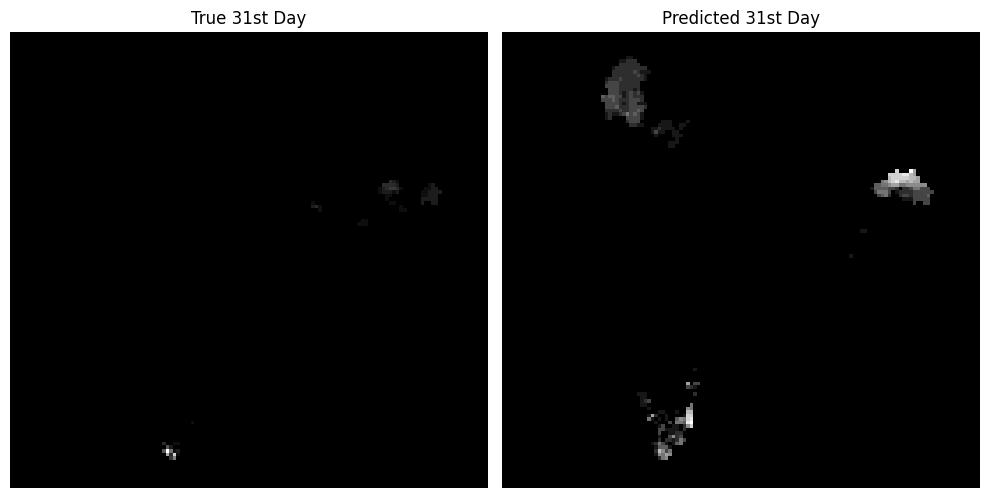

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ✅ Rebuild test generator with batch_size=1
test_gen = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LEN, batch_size=1, shuffle=False)

# ✅ Predict one sample at a time
y_true_all, y_pred_all = [], []

print("⏳ Predicting safely...")

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model.predict(x_batch, verbose=0)
    y_true_all.append(y_batch[0])     # (129,135,1)
    y_pred_all.append(y_pred[0])      # (129,135,1)

# ✅ Convert to arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# ✅ Flatten both arrays for metric calculations
y_true_flat = y_true_all.reshape(len(y_true_all), -1)
y_pred_flat = y_pred_all.reshape(len(y_pred_all), -1)

# ✅ Evaluation
r2 = r2_score(y_true_flat, y_pred_flat)
mse = np.mean((y_true_flat - y_pred_flat) ** 2)
mae = mean_absolute_error(y_true_flat, y_pred_flat)

print(f"\n✅ Test R² Score (30-day): {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# ✅ Visualize prediction
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray')
plt.title("True 31st Day")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray')
plt.title("Predicted 31st Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# ✅ 1. Imports
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# ✅ 2. Parameters
SEQ_LEN = 7
BATCH_SIZE = 16
EPOCHS = 50
IMG_HEIGHT, IMG_WIDTH = 129, 135

# ✅ 3. Generator (Fixed)
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len, batch_size=16, shuffle=True):
        self.image_paths = sorted(image_paths)
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths) - seq_len)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []
        for i in batch_indices:
            seq_imgs = [self._load_image(self.image_paths[i + j]) for j in range(self.seq_len)]
            target_img = self._load_image(self.image_paths[i + self.seq_len])
            X.append(np.stack(seq_imgs, axis=0))
            y.append(target_img)
        return np.array(X), np.array(y)

    def _load_image(self, path):
        img = Image.open(path).convert('L')
        return np.array(img, dtype=np.float32)[..., np.newaxis] / 255.0  # ✅ FIXED

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ✅ 4. Load image paths from year-wise folders
def collect_image_paths(base_path):
    image_paths = []
    for year in sorted(os.listdir(base_path)):
        year_folder = os.path.join(base_path, year)
        if os.path.isdir(year_folder):
            for fname in sorted(os.listdir(year_folder)):
                if fname.endswith('.png') and fname.startswith('IMD_RAIN_'):
                    image_paths.append(os.path.join(year_folder, fname))
    return image_paths

base_path = "/content/Image_all/Image_all"
all_image_paths = collect_image_paths(base_path)
print("✅ Total images found:", len(all_image_paths))

# ✅ 5. Create splits
total_seq = len(all_image_paths) - SEQ_LEN
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)

train_paths = all_image_paths[:-(test_size + val_size)]
val_paths   = all_image_paths[-(test_size + val_size):-test_size]
test_paths  = all_image_paths[-test_size:]

train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = RainfallSequenceGenerator(val_paths,   seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
test_gen  = RainfallSequenceGenerator(test_paths,  seq_len=SEQ_LEN, batch_size=1)

# ✅ 6. Build CNN-LSTM model (128 LSTM units)
def build_cnn_lstm_model(input_shape=(SEQ_LEN, IMG_HEIGHT, IMG_WIDTH, 1)):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(0.3))

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)

    lstm_out = layers.Bidirectional(layers.LSTM(128, activation='tanh', return_sequences=False))(td_cnn)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    dense_out = layers.Dense(IMG_HEIGHT * IMG_WIDTH, activation='relu')(lstm_out)
    output_layer = layers.Reshape((IMG_HEIGHT, IMG_WIDTH, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="CNN_LSTM_Rainfall")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

model = build_cnn_lstm_model()
model.summary()

# ✅ 7. Train and Save
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

model.save("/content/cnn_lstm_7day_128lstm_model_colab_safe.h5")
print("✅ Model saved successfully.")


✅ Total images found: 4017


Model: "CNN_LSTM_Rainfall"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 7, 129, 135, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 7, 32768)       │        93,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │    33,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17415)          │     4,475,655 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 129, 135, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,255,751 (145.93 MB)

 Trainable params: 38,255,303 (145.93 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 49s 210ms/step - loss: 6.0954e-04 - mae: 0.0056 - val_loss: 4.7700e-04 - val_mae: 0.0044
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - loss: 4.4511e-04 - mae: 0.0043 - val_loss: 4.6542e-04 - val_mae: 0.0043
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - loss: 4.3156e-04 - mae: 0.0041 - val_loss: 4.4555e-04 - val_mae: 0.0039
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - loss: 4.1405e-04 - mae: 0.0038 - val_loss: 4.3557e-04 - val_mae: 0.0039
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - loss: 4.2966e-04 - mae: 0.0039 - val_loss: 4.3116e-04 - val_mae: 0.0037
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - loss: 4.1955e-04 - mae: 0.0037 - val_loss: 4.2999e-04 - val_mae: 0.0039
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - loss: 4.1630e-04 - mae: 0.0038 - val_loss: 4.2491e-04 - val_mae: 0.0040
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - loss: 4.1353e-04 - mae: 0.0037 - val_los

✅ Model saved successfully.


✅ Model loaded and compiled.
⏳ Predicting one batch at a time (safe)...

✅ Test R² Score (7-day): 0.7607
📉 Test MSE: 0.000331
📉 Test MAE: 0.003076


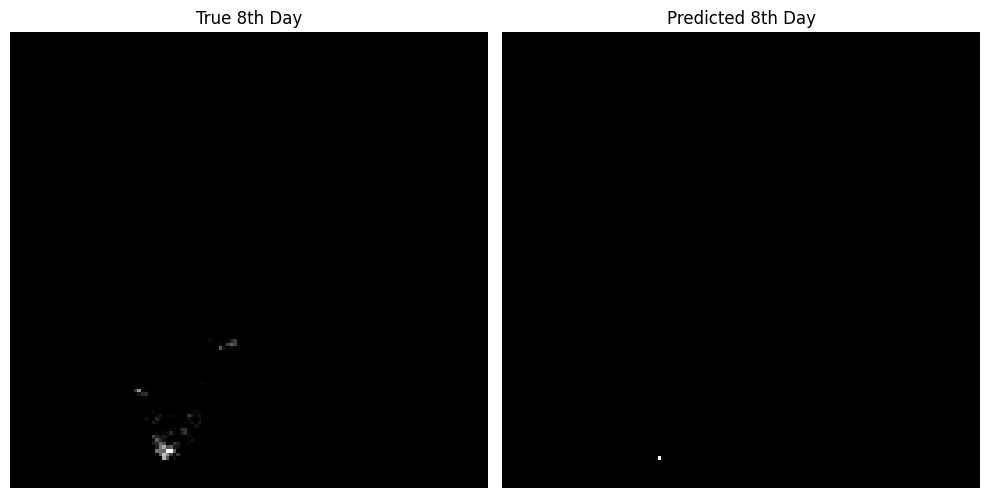

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# === Rebuild the test generator with batch_size=1 to avoid OOM or batch drop
test_gen = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LEN, batch_size=1, shuffle=False)

# === Reload the saved model
model = tf.keras.models.load_model("/content/cnn_lstm_7day_128lstm_model_colab_safe.h5", compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print("✅ Model loaded and compiled.")

# === Predict safely batch-by-batch
y_true_all = []
y_pred_all = []

print("⏳ Predicting one batch at a time (safe)...")
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model(x_batch, training=False).numpy()
    y_true_all.append(y_batch[0])
    y_pred_all.append(y_pred[0])

# Convert to arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# === Compute Metrics
r2 = r2_score(y_true_all.reshape(len(y_true_all), -1), y_pred_all.reshape(len(y_pred_all), -1))
mse = np.mean((y_true_all - y_pred_all) ** 2)
mae = np.mean(np.abs(y_true_all - y_pred_all))

print(f"\n✅ Test R² Score (7-day): {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# === Plot sample prediction
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray')
plt.title("True 8th Day")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray')
plt.title("Predicted 8th Day")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# --- 1. Imports and Setup ---
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# --- 2. Define Sequence Generator ---
class RainfallSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, seq_len=30, batch_size=16, shuffle=True):
        self.image_paths = image_paths
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths) - seq_len)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []
        for i in batch_indices:
            seq_imgs = [self._load_image(self.image_paths[j]) for j in range(i, i + self.seq_len)]
            target_img = self._load_image(self.image_paths[i + self.seq_len])
            X.append(seq_imgs)
            y.append(target_img)
        return np.array(X)[..., np.newaxis], np.array(y)[..., np.newaxis]

    def _load_image(self, path):
        img = Image.open(path).convert('L')
        return np.array(img, dtype=np.float32) / 255.0

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# --- 3. Collect Image Paths ---
def collect_image_paths(base_dir="/content/Image_all"):
    all_paths = []
    for year_folder in sorted(os.listdir(base_dir)):
        year_path = os.path.join(base_dir, year_folder)
        if os.path.isdir(year_path):
            for file in sorted(os.listdir(year_path)):
                if file.endswith(".png") and file.startswith("IMD_RAIN_"):
                    all_paths.append(os.path.join(year_path, file))
    return all_paths

# --- 4. Build Model Function (No changes) ---
def build_cnn_lstm_model(input_shape=(30, 129, 135, 1)):
    cnn = models.Sequential(name="CNN_feature_extractor")
    cnn.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(129, 135, 1)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D((2,2)))

    cnn.add(layers.Flatten())
    cnn.add(layers.Dropout(0.3))

    input_layer = layers.Input(shape=input_shape)
    td_cnn = layers.TimeDistributed(cnn)(input_layer)

    lstm_out = layers.Bidirectional(layers.LSTM(128, activation='tanh', return_sequences=False))(td_cnn)
    lstm_out = layers.Dropout(0.3)(lstm_out)

    dense_out = layers.Dense(129 * 135, activation='relu')(lstm_out)
    output_layer = layers.Reshape((129, 135, 1))(dense_out)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# --- 5. Prepare Data and Train ---
SEQ_LEN = 30
all_image_paths = collect_image_paths("/content/Image_all/Image_all")

total_seq = len(all_image_paths) - SEQ_LEN
test_size = int(0.1 * total_seq)
val_size = int(0.2 * total_seq)

train_paths = all_image_paths[:-(test_size + val_size)]
val_paths = all_image_paths[-(test_size + val_size):-test_size]
test_paths = all_image_paths[-test_size:]

train_gen = RainfallSequenceGenerator(train_paths, seq_len=SEQ_LEN, batch_size=16)
val_gen   = RainfallSequenceGenerator(val_paths, seq_len=SEQ_LEN, batch_size=16)
test_gen  = RainfallSequenceGenerator(test_paths, seq_len=SEQ_LEN, batch_size=1, shuffle=False)

model = build_cnn_lstm_model(input_shape=(SEQ_LEN, 129, 135, 1))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

# --- 6. Save the Model ---
model.save("/content/cnn_lstm_30day_128lstm_model_colab_safe.h5")
print("✅ Model saved as cnn_lstm_30day_128lstm_model_colab_safe.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 155s 726ms/step - loss: 5.9786e-04 - mae: 0.0058 - val_loss: 4.5222e-04 - val_mae: 0.0043
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 123s 705ms/step - loss: 4.4438e-04 - mae: 0.0043 - val_loss: 4.4495e-04 - val_mae: 0.0044
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 122s 702ms/step - loss: 4.6394e-04 - mae: 0.0043 - val_loss: 4.2657e-04 - val_mae: 0.0038
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 122s 701ms/step - loss: 4.3421e-04 - mae: 0.0041 - val_loss: 4.2417e-04 - val_mae: 0.0037
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 123s 706ms/step - loss: 4.2747e-04 - mae: 0.0040 - val_loss: 4.1878e-04 - val_mae: 0.0038
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 122s 699ms/step - loss: 4.4245e-04 - mae: 0.0041 - val_loss: 4.2136e-04 - val_mae: 0.0037
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 122s 701ms/step - loss: 4.2916e-04 - mae: 0.0039 - val_loss: 4.1629e-04 - val_mae: 0.0038
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 129s 741ms/step - loss: 4.2221e-04 - mae: 0.0039 -

✅ Model saved as cnn_lstm_30day_128lstm_model_colab_safe.h5


⏳ Predicting one batch at a time (safe)...

✅ Test R² Score: 0.7583
📉 Test MSE: 0.000358
📉 Test MAE: 0.003167


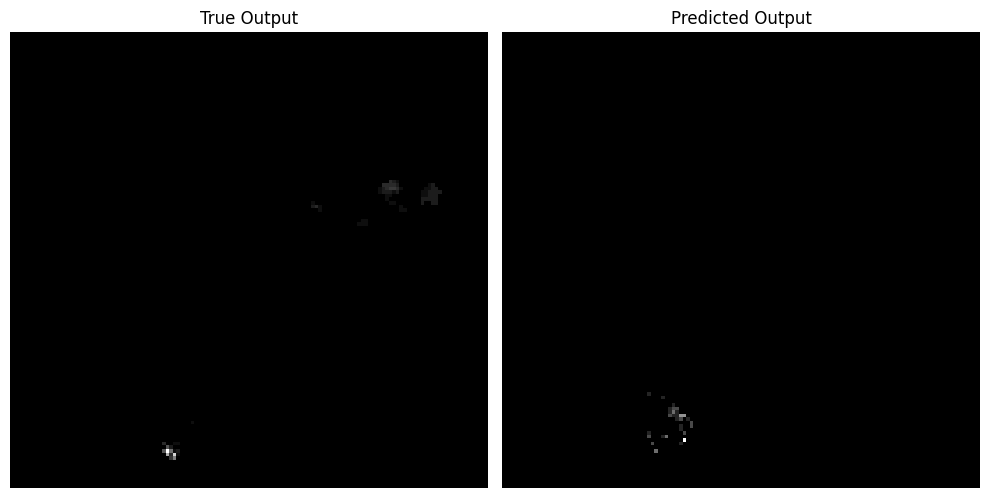

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Use the test generator already in memory
# (e.g., `test_gen = RainfallSequenceGenerator(...)` was previously executed)

y_true_all = []
y_pred_all = []

print("⏳ Predicting one batch at a time (safe)...")
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    y_pred = model(x_batch, training=False).numpy()
    y_true_all.append(y_batch[0])
    y_pred_all.append(y_pred[0])

# Convert to arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Metrics
r2 = r2_score(y_true_all.reshape(len(y_true_all), -1), y_pred_all.reshape(len(y_pred_all), -1))
mse = np.mean((y_true_all - y_pred_all) ** 2)
mae = np.mean(np.abs(y_true_all - y_pred_all))

print(f"\n✅ Test R² Score: {r2:.4f}")
print(f"📉 Test MSE: {mse:.6f}")
print(f"📉 Test MAE: {mae:.6f}")

# Visualization
true_img = (y_true_all[0] * 255).astype(np.uint8).squeeze()
pred_img = (y_pred_all[0] * 255).astype(np.uint8).squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_img, cmap='gray')
plt.title("True Output")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray')
plt.title("Predicted Output")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
!nvidia-smi


Sun Apr 13 17:20:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("\n--- Device Details ---")
device_lib.list_local_devices()


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

--- Device Details ---


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7534319554145409659
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11371769233180844710
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload something like 'my_sequence.zip'


Saving sequence.zip to sequence.zip


In [ ]:
import zipfile
import os

zip_path = "/content/sequence.zip"  # Use your uploaded zip name
extract_path = "custom_sequence"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted to: {extract_path}")


✅ Extracted to: custom_sequence


In [ ]:
from PIL import Image
import numpy as np
import os

def load_sequence(folder, expected_size=(129, 135)):
    sequence_images = []

    # Ensure sorted order like day_01.png to day_30.png
    image_files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    if len(image_files) != 30:
        raise ValueError("❌ You must provide exactly 30 images for prediction.")

    for fname in image_files:
        img_path = os.path.join(folder, fname)
        img = Image.open(img_path).convert('L')  # Ensure grayscale
        img_resized = img.resize(expected_size[::-1])  # Resize to (135, 129)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0  # Normalize
        sequence_images.append(img_array)

    # Convert to proper input shape: (1, 30, 129, 135, 1)
    input_seq = np.array(sequence_images)[np.newaxis, ..., np.newaxis]
    return input_seq


In [ ]:
input_sequence = load_sequence("custom_sequence/sequence")
print("✅ Final input shape:", input_sequence.shape)


✅ Final input shape: (1, 30, 129, 135, 1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model_path = "/content/drive/My Drive/cnn_lstm_30day_model.h5"
model = load_model(model_path, compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print("✅ Model loaded successfully.")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/My Drive/cnn_lstm_30day_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
# 📁 Upload BOTH 'full_data.zip' (full dataset) and 'sequence.zip' (30-day monsoon images)
from google.colab import files
uploaded = files.upload()


Saving Image_all.zip to Image_all.zip
Saving sequence.zip to sequence.zip


In [6]:
# 📦 Extract uploaded ZIPs to separate folders
import zipfile, os

for fname in uploaded:
    extract_path = f"/content/{os.path.splitext(fname)[0]}"
    with zipfile.ZipFile(fname, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Extracted {fname} to {extract_path}")


✅ Extracted Image_all.zip to /content/Image_all
✅ Extracted sequence.zip to /content/sequence


In [9]:
# ✅ Load grayscale images (135x129) and fetch paths from all subfolders
import numpy as np
from PIL import Image
import os

def load_image(path):
    img = Image.open(path).convert("L").resize((135, 129))
    return np.array(img, dtype=np.float32) / 255.0

def get_image_paths(root):
    all_paths = []
    for dirpath, _, filenames in os.walk(root):  # ✅ Recursively walk through all subfolders
        for f in filenames:
            if f.endswith(".png"):
                all_paths.append(os.path.join(dirpath, f))
    return sorted(all_paths)

# ✅ Use updated function to get all images recursively
full_paths = get_image_paths("/content/Image_all")
monsoon_paths = get_image_paths("/content/monsoon_30")

print(f"✅ Found {len(full_paths)} training images")
print(f"✅ Found {len(monsoon_paths)} monsoon images")



✅ Found 4017 training images
✅ Found 30 monsoon images


In [10]:
import random

SEQ_LENGTH = 30
TRAIN_SAMPLES = min(300, len(full_paths) - SEQ_LENGTH)  # Ensure safe sampling

X_train, y_train = [], []

for i in range(TRAIN_SAMPLES):
    start = random.randint(0, len(full_paths) - SEQ_LENGTH - 1)
    seq = [load_image(full_paths[j]) for j in range(start, start + SEQ_LENGTH)]
    target = load_image(full_paths[start + SEQ_LENGTH])
    X_train.append(seq)
    y_train.append(target)

X_train = np.expand_dims(np.array(X_train), -1)  # (samples, 30, 129, 135, 1)
y_train = np.expand_dims(np.array(y_train), -1)  # (samples, 129, 135, 1)

print(f"✅ Training samples used: {TRAIN_SAMPLES}")
print("✅ X_train shape:", X_train.shape)
print("✅ y_train shape:", y_train.shape)


✅ Training samples used: 300
✅ X_train shape: (300, 30, 129, 135, 1)
✅ y_train shape: (300, 129, 135, 1)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_lstm_model(input_shape):
    cnn = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(129, 135, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3)
    ])

    input_layer = layers.Input(shape=input_shape)
    td = layers.TimeDistributed(cnn)(input_layer)
    lstm = layers.Bidirectional(layers.LSTM(128))(td)
    dense = layers.Dense(129 * 135, activation='relu')(lstm)
    output = layers.Reshape((129, 135, 1))(dense)

    model = models.Model(input_layer, output)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_cnn_lstm_model((SEQ_LENGTH, 129, 135, 1))
model.fit(X_train, y_train, epochs=5, batch_size=8, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - loss: 5.0543e-04
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 4.0474e-04
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - loss: 4.1497e-04
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 3.4399e-04
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 3.8593e-04


In [12]:
# --- Prepare the 30-day monsoon sequence for prediction ---
X_monsoon = [load_image(p) for p in monsoon_paths]  # Load all 30 images
X_monsoon = np.array(X_monsoon)  # Shape: (30, 129, 135)
X_monsoon = np.expand_dims(X_monsoon, axis=0)  # Shape: (1, 30, 129, 135)
X_monsoon = np.expand_dims(X_monsoon, axis=-1)  # Shape: (1, 30, 129, 135, 1)

# --- Predict the 31st day rainfall image ---
pred = model.predict(X_monsoon, verbose=0)[0].squeeze()  # Shape: (129, 135)
print("✅ Prediction complete!")


✅ Prediction complete!


<ipython-input-13-b0479fdfd443>:8: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


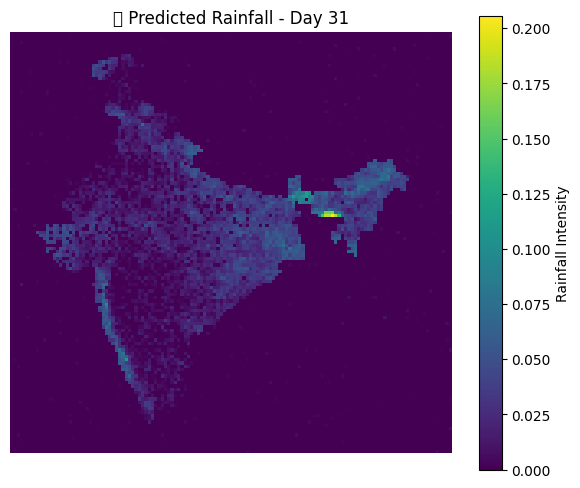

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(pred, cmap='viridis')  # You can also try 'jet' or 'plasma'
plt.colorbar(label='Rainfall Intensity')
plt.title("🌧️ Predicted Rainfall - Day 31")
plt.axis('off')
plt.tight_layout()
plt.show()


In [22]:
# Choose index (e.g., 24 for 25th image)
index = 0

# Load the N-th image from monsoon_paths
ref_img = load_image(monsoon_paths[index])  # shape: (129, 135), values [0, 1]
ref_img = (ref_img * 255).astype(np.uint8)

# Convert predicted image as well
pred_img = (pred * 255).astype(np.uint8)



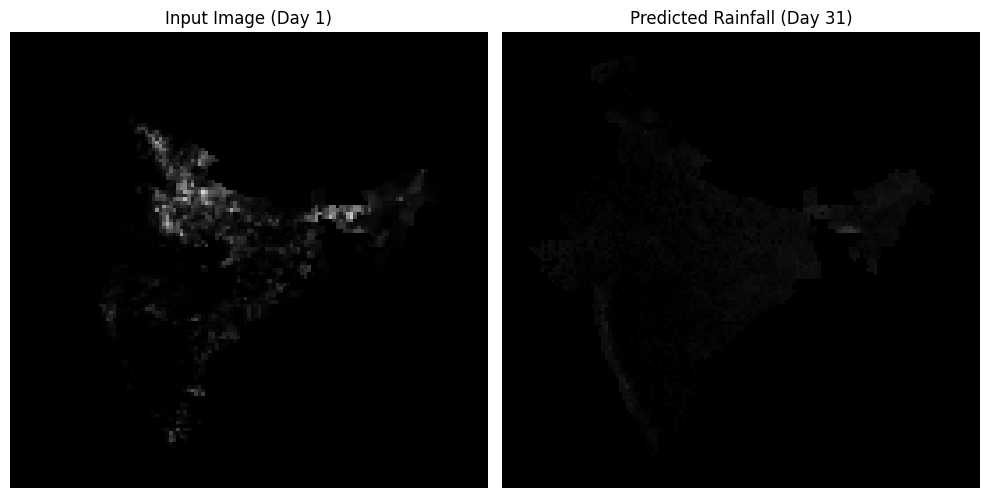

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ref_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Input Image (Day {index+1})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_img, cmap='gray', vmin=0, vmax=255)
plt.title("Predicted Rainfall (Day 31)")
plt.axis('off')

plt.tight_layout()
plt.show()
